## Binary Logistic Regression

For the shared words, we find that homonymous and polysemous senses are able to be distinguished

In [2]:
import numpy as np
import pandas as pd
from core.analysis import *
from core import semcor_bert_pipeline
from core.metrics import *

<Figure size 432x288 with 0 Axes>

In [17]:
shared_metrics = {} #This dictionary saves the model results in a dictionary.
shared_words = ['foot.n', 'plane.n', 'model.n', 'table.n', 'degree.n', 'right.n']

fmt_sense_12 = lambda w: [w + '.01', w + '.02']
shared_senses = [fmt_sense_12(w) for w in shared_words]
shared_senses[-2] = ['degree.n.01', 'academic_degree.n.01']
shared_senses[1] = ['airplane.n.01', 'plane.n.02']
for w_s in zip(shared_words, shared_senses):
    model_data = binary_logistic(w_s[0], w_s[1]) #Trains full model
    weight_values, weight_indices = nonzero_weights(model_data['model'])
    f_scores, accuracies, wrong_indices, cnf = k_fold_cv(model_data['data'], model_data['transformed_labels'], k = 5)
    #Get accuracies/F score via 5 fold cross validation
    shared_metrics[w_s[0]] = {'senses': w_s[1], 'data': model_data, 'weights': weight_values,
                    'weight_indices': weight_indices, 'f1_kfold': f_scores, 'acc_kfold': accuracies,
                             'incorrect_indices': wrong_indices}
    

['foot.n.01', 'foot.n.02']
['airplane.n.01', 'plane.n.02']
['model.n.01', 'model.n.02']
['table.n.01', 'table.n.02']
['degree.n.01', 'academic_degree.n.01']
['right.n.01', 'right.n.02']


Plotting stats in a table

In [18]:
shared_stats = []
incorrect = []
for k in shared_metrics:
    word_results = shared_metrics[k]
    weights = word_results['weights']
    incorrect.append(misclassified_sentences(word_results['data'], word_results['incorrect_indices']))
    shared_stats.append({'word_type': k, 'avg_f1': np.mean(word_results['f1_kfold']), 'avg_acc': np.mean(word_results['acc_kfold']),
    'pct_nonzero_weights': len(weights) / 768, 'max_wt': max(weights), 'min_wt': min(weights), 'mean_nonzero_wt': np.mean(weights), 'sd_nonzero_wt': np.std(weights)})
pd.DataFrame(shared_stats)

,word_type,avg_f1,avg_acc,pct_nonzero_weights,max_wt,min_wt,mean_nonzero_wt,sd_nonzero_wt
0,foot.n,1.000000,1.000000,0.027344,0.300073,-0.370610,-0.000041,0.162395
1,plane.n,1.000000,1.000000,0.019531,0.455467,-0.292434,0.029947,0.191032
2,model.n,0.962963,0.966667,0.022135,0.392603,-0.229521,0.028416,0.162110
3,table.n,1.000000,1.000000,0.023438,0.235935,-0.217856,0.026317,0.135491
4,degree.n,1.000000,1.000000,0.016927,0.310832,-0.240648,-0.022754,0.146796
5,right.n,0.982745,0.980000,0.013021,0.183536,-0.700819,-0.048611,0.239237


Average F1 score of homonymous/polysemous classification

In [3]:
np.mean([0.962963, 0.982745, 1, 1, 1, 1])

0.9909513333333333

## Applying the Probe to All Senses 

We train the probe, plot confusion matrices, and see instances that are misclassified.

In [2]:
with open('../data/stimuli.json') as f:
    db = json.load(f)

In [3]:
shared_model_data = {} #Contains results for cross validation
shared_stats = []
incorrect = []
shared_words = ['foot.n', 'plane.n', 'model.n', 'table.n', 'degree.n', 'right.n']
for w in shared_words:
    print(w) #Checking where the model doesn't converge
    model_results = logistic_cv(w, sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.n', "_n"))],
                               use_masc = False)
    shared_model_data[w] = model_results
    shared_stats.append({"word": w, 'avg_f1': np.mean(model_results['f1']),
                         'avg_acc': np.mean(model_results['acc'])})    
    incorrect.append(misclassified_sentences(model_results, model_results['incorrect_indices']))

foot.n
plane.n


/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


model.n


/anaconda3/envs/bert/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


table.n
degree.n
right.n


Confusion Matrices

/anaconda3/envs/bert/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


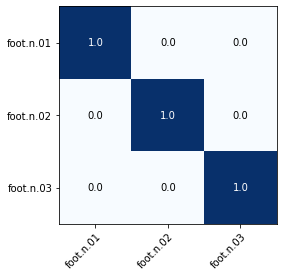

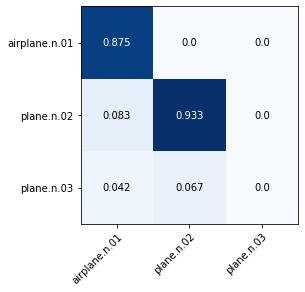

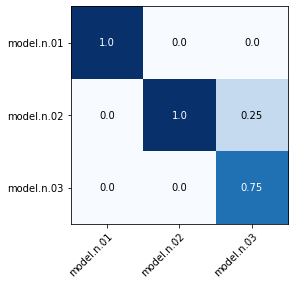

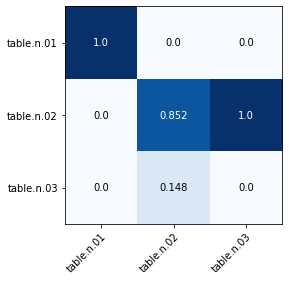

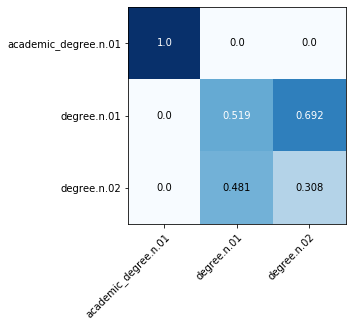

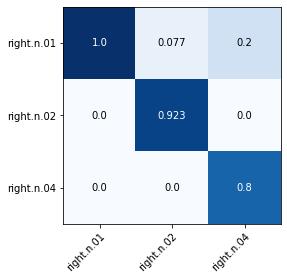

In [32]:
for w in shared_words:
    word_matrices = shared_model_data[w]['confusion_matrices']
    senses = [fb_to_local(s) for s in get_senses(db, w.replace('.n', "_n"))]
    plot_confusion_mtx(word_matrices, senses)

In [16]:
pd.set_option('display.max_colwidth', 500)

pd.concat(incorrect)

,true_label,sentences
0,foot.n.02,"Hans Schweizer had one that increased from 19 - 1 2 inches to 5 feet 3 inches in five years , and J . J . Quelch records a growth of from less than 4 feet to nearly 10 in about six years ."
0,plane.n.02,"If a is the major axis of an ellipsoid and b and c are the other two axes , the radius of curvature in the ab plane at the end of the axis is * * f , and the difference in pressure along the a and b axes is * * f ."
1,plane.n.02,"Also , planetary gravitational attraction increases the dust concentration near the plane of the ecliptic as the sun is approached ."
0,model.n.03,He worked for two hours a day with each model sent by the rabbi .
1,model.n.03,His first model arrived at dusk .
0,table.n.01,"Although the standard deviation values on which spread of the lines are based are relatively larger for those centers which begin to ossify early ( Table 1 ) , there are considerable differences in this value between centers having the closely timed Onsets ."
1,table.n.01,It was stated earlier that one purpose of this study was to extend the analysis of variability of Onset and Completion in each of the 21 growth centers somewhat beyond that provided by the data in Tables 1 and 2 .
2,table.n.01,"It may be assumed that differences in ratings due to selection of growth centers from specific regions of the body will be small , according to existing tables of onset age and completion age for centers throughout the body ."
0,academic_degree.n.01,Dr. Clark holds an earned Doctor of Education degree from the University of Oklahoma .
1,academic_degree.n.01,"He also received a Master of Science degree from Texas A+I College and a Bachelor of Science degree from Southwestern State College , Weatherford , Okla. ."


## Weight Analyses

If we look at cosine distance of centroids, will we achieve comparable results using only the embeddings at indices that had nonzero weights? Here, we apply the same analyses that we did comparing the experiment data to the centroids of the full BERT embeddings (MDS and correlation)

In [37]:
for w in shared_model_data.keys():
    print(w)
    results = shared_model_data[w]
    save_embeds_with_wts(results['data'], results['labels'], results['weights'], w)
    #Here, we print the percentage of weights that are important in discriminating between senses

foot.n
0.19010416666666666
plane.n
0.05078125
model.n
0.046875
table.n
0.10546875
degree.n
0.06901041666666667
right.n
0.0703125


In [68]:
from sklearn.manifold import MDS

In [5]:
shared_words = ['foot.n', 'plane.n', 'model.n', 'table.n', 'degree.n', 'right.n']


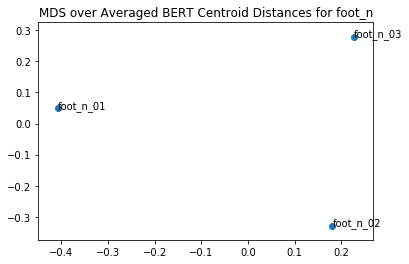

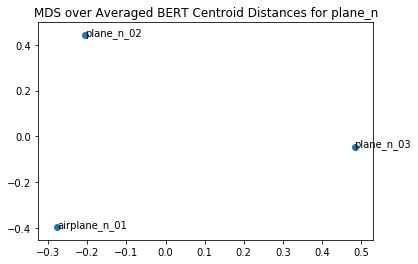

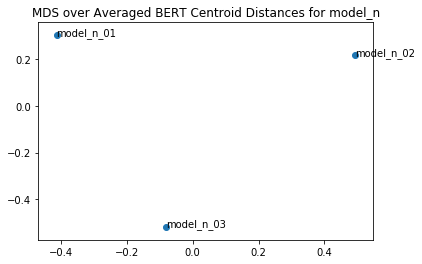

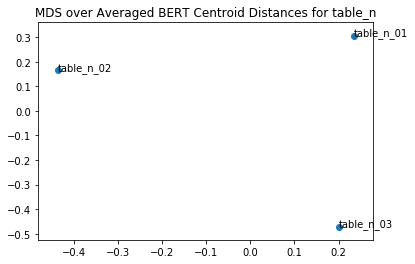

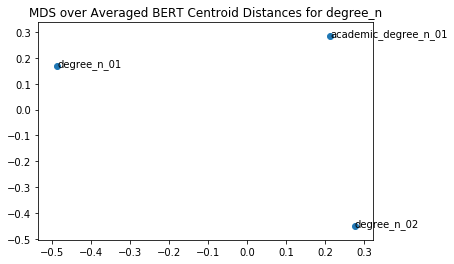

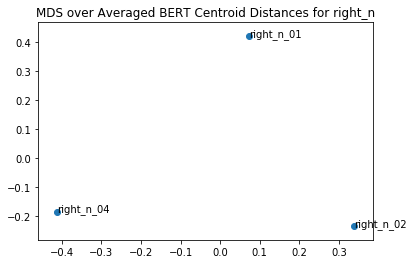

In [4]:
for w in shared_words:
    result_mtx, sense_names = cosine_sim_mtx(w.replace('.n', ''), 'n',sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.', "_"))],
                                            corpus = 'select_weights', use_masc = False, normalize = False)
    mds_model = MDS(n_components = 2, dissimilarity = 'precomputed')
    plot_mds(result_mtx, w.replace('.', '_'), mds_model, db, "BERT Centroid")

In [3]:
results = pd.read_csv('../data/approved_expt_results.csv')
incl_users = results['userID'].unique()

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


In [6]:

shared_words = [w.replace('.', '_') for w in shared_words]
matrices = {w: {} for w in shared_words}

#print("Spearman Rank Correlations for Shared Words")
for w in shared_words:
    expt_means = mean_distance_mtx(results, w.replace('.', '_'), 'shared', incl_users, normalize = True)
    matrices[w]['expt'] = expt_means
    word, pos = w.split("_")
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w.replace('.', '_'))],
                                         corpus = 'select_weights', use_masc = False)
    bert_cs = normalize_cos_dist(bert_cs)
    matrices[w]['bert'] = bert_cs


In [7]:
all_human_avg = [matrices[w]['expt'] for w in shared_words]
all_bert_cs = [matrices[w]['bert'] for w in shared_words]
bert_human_shared = mtx_correlation(all_human_avg, all_bert_cs, method = 'pearson')
bert_human_shared

0.6963979090033697

For reference, using the full set of BERT embeddings, the correlation was 0.75